In [1]:
from Run import Run
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from dk_utilities import get_signal_times

In [4]:
# get baseline information (from random triggers without beam)

folder = "C:/Users/Karlen/Documents/temp/"

run503 = Run.open_file(folder+"run_000503.dk")
baseline_means = run503.user['baseline_means']
baseline_stds = run503.user['baseline_stds']

In [162]:
# Look at ACT signal amplitude distributions by integrating over a fixed window with a delay defined by a trig1 pulse
# Done prior to having a good t0 from accelerator RF

# special runs:
# 384,385,386 - n = 1.01 and p = -0.94, -1, -1.06 GeV: good to look at small ACT signals (lead glass veto)
# 464 - no electron veto
# 502 - random during spill (no electron veto)
# 503 - random during beam off
# negative 1. GeV beam
# others: 388, 452, 463, 474

signal_run_number = 384
signal_run = Run.open_file(folder+"run_000"+str(signal_run_number)+".dk")
signal_config = signal_run.config

if 'signal_times' in signal_run.user:
    signal_signal_times = signal_run.user['signal_times']
else:
    signal_signal_times = None

background_run_number = 503
background_run = Run.open_file(folder+"run_000"+str(background_run_number)+".dk")
background_config = background_run.config

if 'signal_times' in background_run.user:
    background_signal_times = background_run.user['signal_times']
else:
    background_signal_times = None

voltage_scale = signal_config["VoltageScale"]

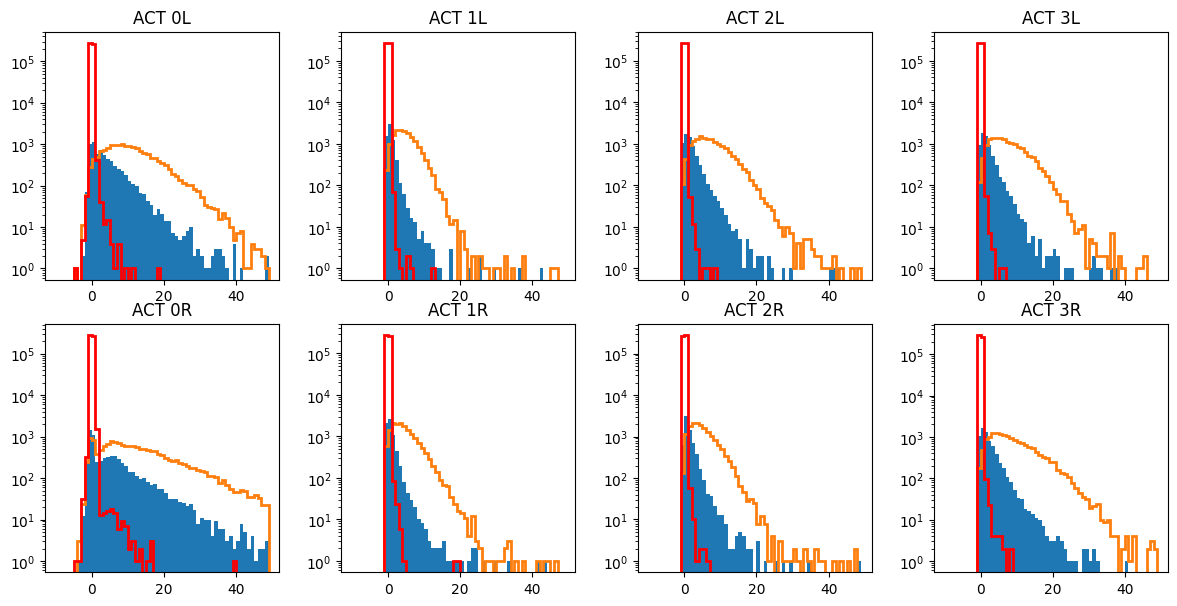

In [163]:
# adjust window width and delay to optimize separation of signal and background
# use runs (384, 385, 386, with lead glass veto) as small signal and run503 (use a fixed trig1 time) as background

pb_max_dict = {
    386:50,
    385:50,
    384:42,
    389:40,
    390:35,
    391:30
}

trig0_chans = [8,9] # require exactly 1 peak in each
trig1_chan = 12 # use this for reference time
act_chans = [0,1,2,3,4,5,6,7] # leave this alone
pb_chan = 18
pb_delay = -5
pb_bins = 50
pb_sum_max = pb_max_dict[signal_run_number]
act_delay = -30
act_bins = 25

signal_act_sums = [[] for i in range(len(act_chans))]
e_signal_act_sums = [[] for i in range(len(act_chans))]
background_act_sums = [[] for i in range(len(act_chans))]

signal_act23 = []
e_signal_act23 = []
background_act23 = []

# signal selection: trigger 0 and 1 and lead glass
run = signal_run
for ie in range(len(signal_signal_times[0])):
    if len(signal_signal_times[trig0_chans[0]][ie]) == 1 and len(signal_signal_times[trig0_chans[1]][ie]) == 1 and len(signal_signal_times[pb_chan][ie]) == 1 and len(signal_signal_times[trig1_chan][ie]) == 1:
        t00 = signal_signal_times[trig0_chans[0]][ie][0]
        t01 = signal_signal_times[trig0_chans[1]][ie][0]
        if 30 < t00 < 45 and 30 < t01 < 45:
            pb_waveform = run.analyses[pb_chan].raw_waveforms[ie]
            pb_sum = 0.
            it1 = int(signal_signal_times[trig1_chan][ie][0])
            if it1 > 35:
                for it in range(it1+pb_delay, it1+pb_delay+pb_bins):
                    pb_sum += pb_waveform[it] - baseline_means[pb_chan]

                if -1.*pb_sum*voltage_scale < pb_sum_max:
                    for ia, act_chan in enumerate(act_chans):
                        act_sum = 0
                        act_waveform = run.analyses[act_chan].raw_waveforms[ie]
                        for it in range(it1+act_delay, it1+act_delay+act_bins):
                            act_sum += act_waveform[it] - baseline_means[act_chan]
                        signal_act_sums[act_chan].append(-1.*act_sum*voltage_scale)
                        if act_chan > 3:
                            signal_act23.append(-1.*act_sum*voltage_scale)
                else:
                    for ia, act_chan in enumerate(act_chans):
                        act_sum = 0
                        act_waveform = run.analyses[act_chan].raw_waveforms[ie]
                        for it in range(it1+act_delay, it1+act_delay+act_bins):
                            act_sum += act_waveform[it] - baseline_means[act_chan]
                        e_signal_act_sums[act_chan].append(-1.*act_sum*voltage_scale)
                        if act_chan > 3:
                            e_signal_act23.append(-1.*act_sum*voltage_scale)

# background selection: fixed times (get multiple from a single event
run = background_run
for ie in range(len(background_signal_times[0])):
    for it1 in [40,80,120,160,200]:
        for ia, act_chan in enumerate(act_chans):
            act_sum = 0
            act_waveform = run.analyses[act_chan].raw_waveforms[ie]
            for it in range(it1+act_delay, it1+act_delay+act_bins):
                act_sum += act_waveform[it] - baseline_means[act_chan]
            background_act_sums[act_chan].append(-1.*act_sum*voltage_scale)
            if act_chan > 3:
                background_act23.append(-1.*act_sum*voltage_scale)

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
fig.tight_layout()

for row, lr in enumerate(range(2)):
    for col, module in enumerate(range(4)):
        act_chan = 2*module + lr
        axs[row][col].set_title('ACT '+str(module)+['L','R'][lr])

        axs[row][col].hist(signal_act_sums[act_chan],bins=np.arange(-10.,50.,1.))
        axs[row][col].hist(e_signal_act_sums[act_chan],bins=np.arange(-10.,50.,1.), histtype='step', linewidth=2)
        axs[row][col].hist(background_act_sums[act_chan],bins=np.arange(-10.,50.,1.), histtype='step', linewidth=2, color='r')
        axs[row][col].set_yscale('log')

plt.savefig(folder+f'act_detail_{signal_run_number}.png')
plt.show()

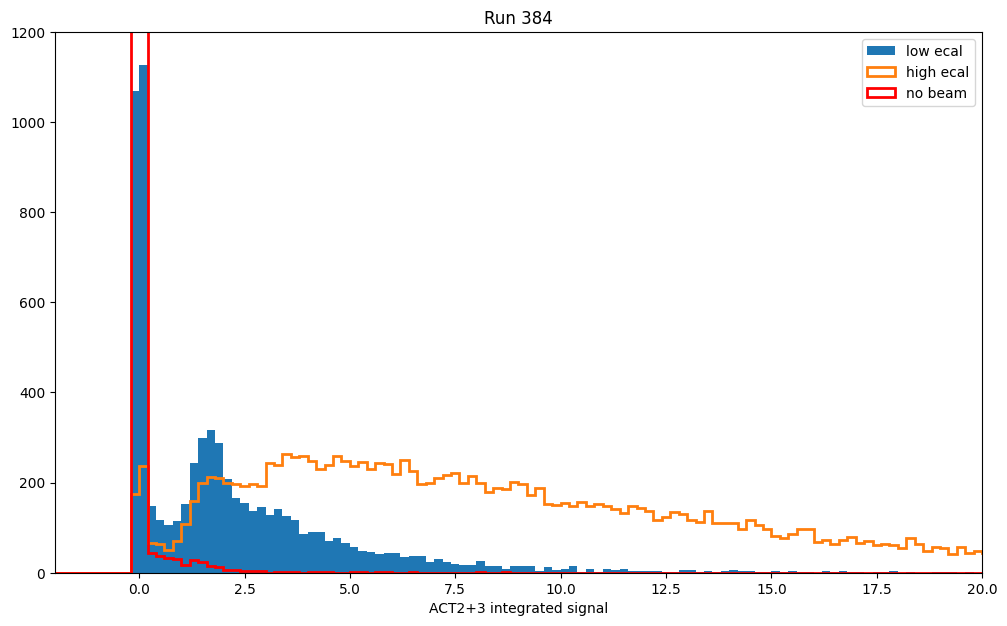

In [164]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
fig.tight_layout()

plt.title(f'Run {signal_run_number}')

axs.hist(signal_act_sums[act_chan],bins=np.arange(-2.,21.,0.2),label='low ecal')
axs.hist(e_signal_act_sums[act_chan],bins=np.arange(-2.,21.,0.2), histtype='step', linewidth=2,label='high ecal')
axs.hist(background_act_sums[act_chan],bins=np.arange(-2.,21.,0.2), histtype='step', linewidth=2, color='r', label='no beam')
#axs.set_yscale('log')
axs.set_ylim(0,1200)
axs.set_xlim(-2,20)
axs.set_xlabel('ACT2+3 integrated signal')
plt.legend()

plt.savefig(folder+f'act23_{signal_run_number}.png')
plt.show()

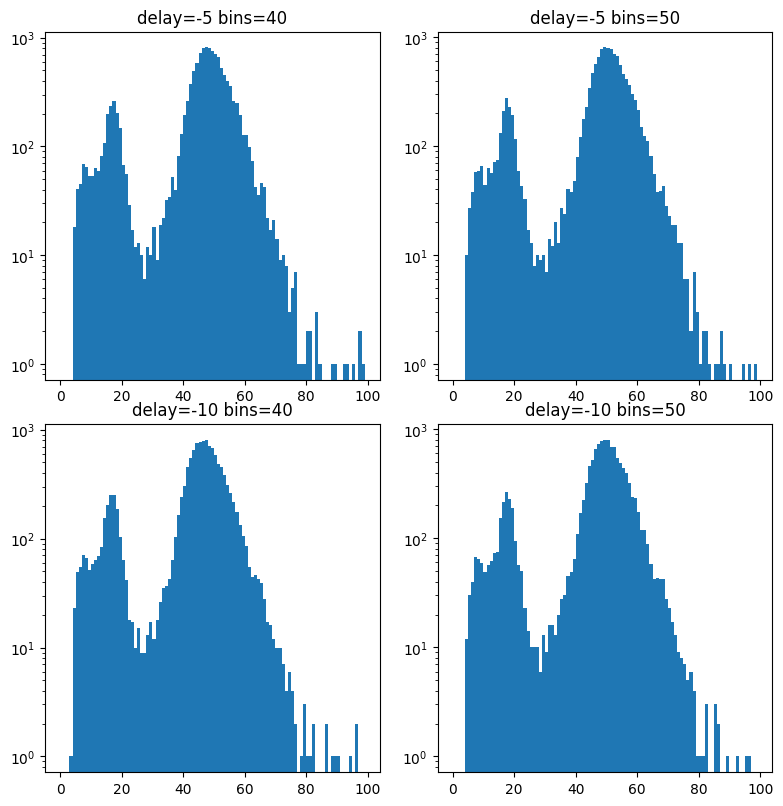

In [132]:
# look at pb glass signals
trig0_chans = [8,9]
trig1_chan = 12
pb_chan = 18
pb_delays = [-5, -10]
pb_binss = [40, 50]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.tight_layout()

for row,pb_delay in enumerate(pb_delays):
    for col,pb_bins in enumerate(pb_binss):
        axs[row][col].set_title('delay='+str(pb_delay)+' bins='+str(pb_bins))

        pb_sums = []
        run = signal_run
        for ie in range(len(signal_signal_times[0])):
            if len(signal_signal_times[trig0_chans[0]][ie]) == 1 and len(signal_signal_times[trig0_chans[1]][ie]) == 1 and len(signal_signal_times[pb_chan][ie]) == 1 and len(signal_signal_times[trig1_chan][ie]) == 1:
                t00 = signal_signal_times[trig0_chans[0]][ie][0]
                t01 = signal_signal_times[trig0_chans[1]][ie][0]
                if 30 < t00 < 45 and 30 < t01 < 45:
                    pb_waveform = run.analyses[pb_chan].raw_waveforms[ie]
                    pb_sum = 0.
                    it1 = int(signal_signal_times[trig1_chan][ie][0])
                    for it in range(it1+pb_delay, it1+pb_delay+pb_bins):
                        pb_sum += pb_waveform[it] - baseline_means[pb_chan]
                    pb_sums.append(-1.*pb_sum*voltage_scale)

        axs[row][col].hist(pb_sums,bins=np.arange(0.,100.,1.))
        axs[row][col].set_yscale('log')
plt.show()

# pb cuts (by eye) for delay = -5 and bins = 50
# 386 (1.06) 50
# 385 (1.0)  50
# 384 (0.94) 42
# 389 (0.9)  40
# 390 (0.8)  35
# 391 (0.7)  30

